# Lab 4 - Comparison of Binary Classifiers

In this exercise we use a breast cancer dataset (see https://www.kaggle.com/uciml/breast-cancer-wisconsin-data). All columns in this dataset are numerical except the column `diagnosis` which is ordinal. Each example is a breast cancer case with diagnosis either M (malignant) or B (benign).

We will train a binary classification model to predict the diagnosis. We assume that misclassifying diagnosis M as B is more costly than misclassifying B as M, as cases classified as M can be further tested, while malignant cases misclassified as B may remain unnoticed. In other words, we would like to train a model that has high recall for class M, while the precision of the model for class M is not that important.

The `diagnosis` column is the *dependent variable* or *target* for classification, while all other columns are the *predictors*. We will use the common convention to refer to the predictors as **X** and to the target as **y**.  

In the process of training the dataset will be split into a training set and a test set. The training set will be further split (multiple times) into a training and validation set in a cross-validation procedure for tuning the parameters of two alternative classifiers: SVM and Random Forest.

Note that any data preparation of the predictors needs to be applied separately to each of these sets.

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## EDA - Exploratory Data Analysis

In [2]:
df = pd.read_csv("./bcwd.csv")
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
df.tail()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
568,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


In [4]:
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

First of all let's check for missing values and outliers.

In [5]:
df.isna().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

There are no missing values. Let's check the boxplots of the numerical columns for outliers. We will do this in three slices.

In [6]:
df.loc[:,'radius_mean':'fractal_dimension_mean'].describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440


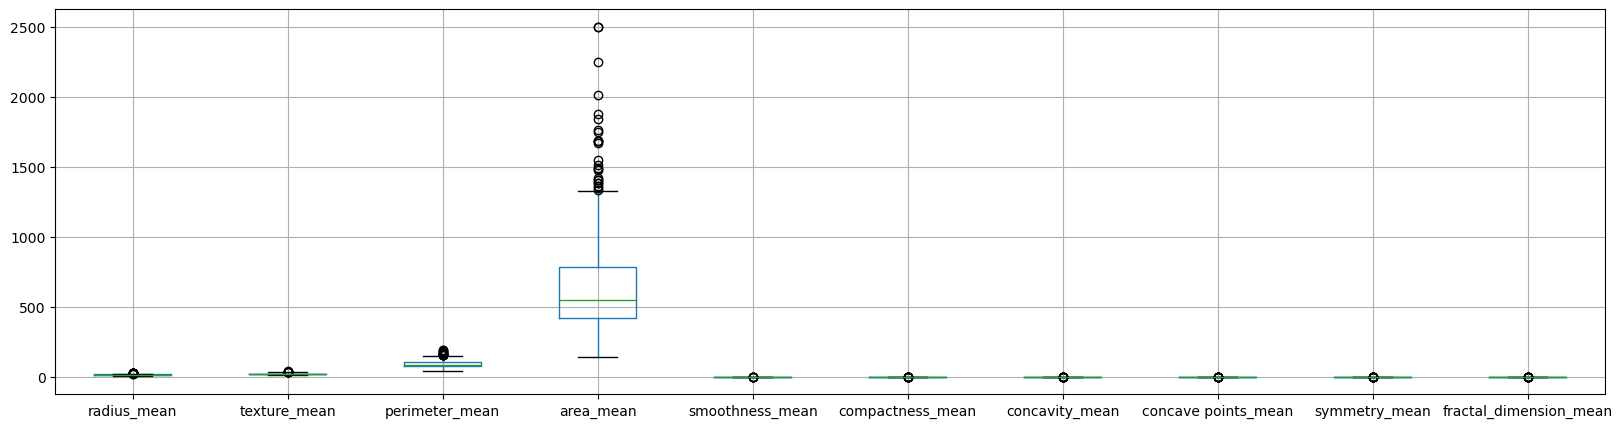

In [7]:
df.loc[:,'radius_mean':'fractal_dimension_mean'].boxplot(figsize=(20,5))
plt.show()

In [8]:


df.loc[:,'radius_se':'fractal_dimension_se'].describe()

,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795
std,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646
min,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895
25%,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248
50%,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187
75%,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558
max,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840


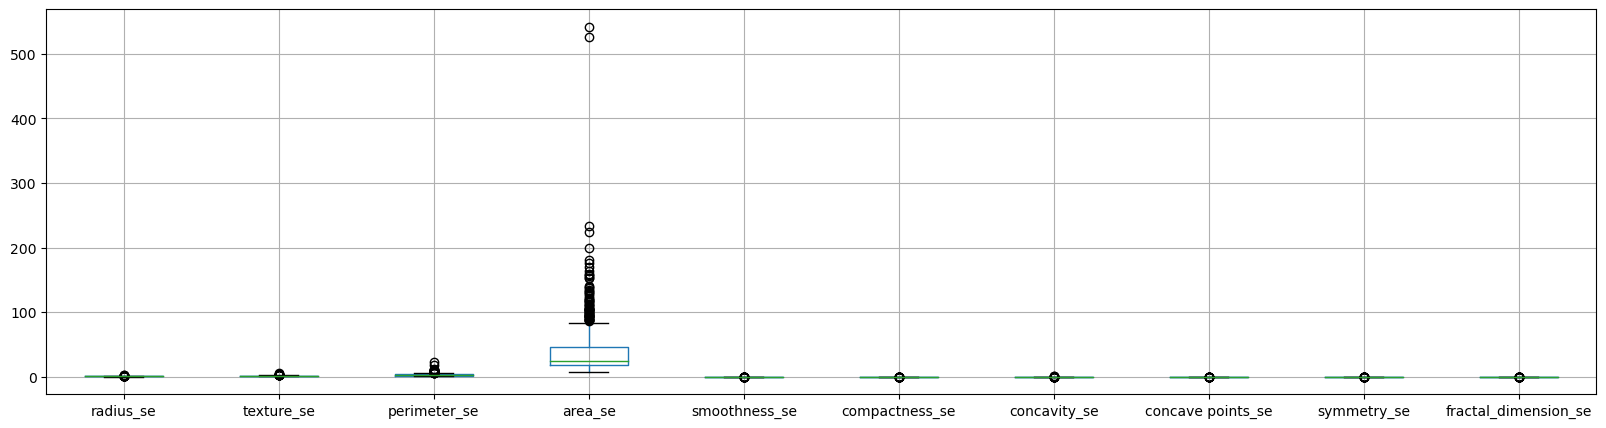

In [9]:
df.loc[:,'radius_se':'fractal_dimension_se'].boxplot(figsize=(20,5))
plt.show()

In [10]:
df.loc[:,'radius_worst':'fractal_dimension_worst'].describe()

,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


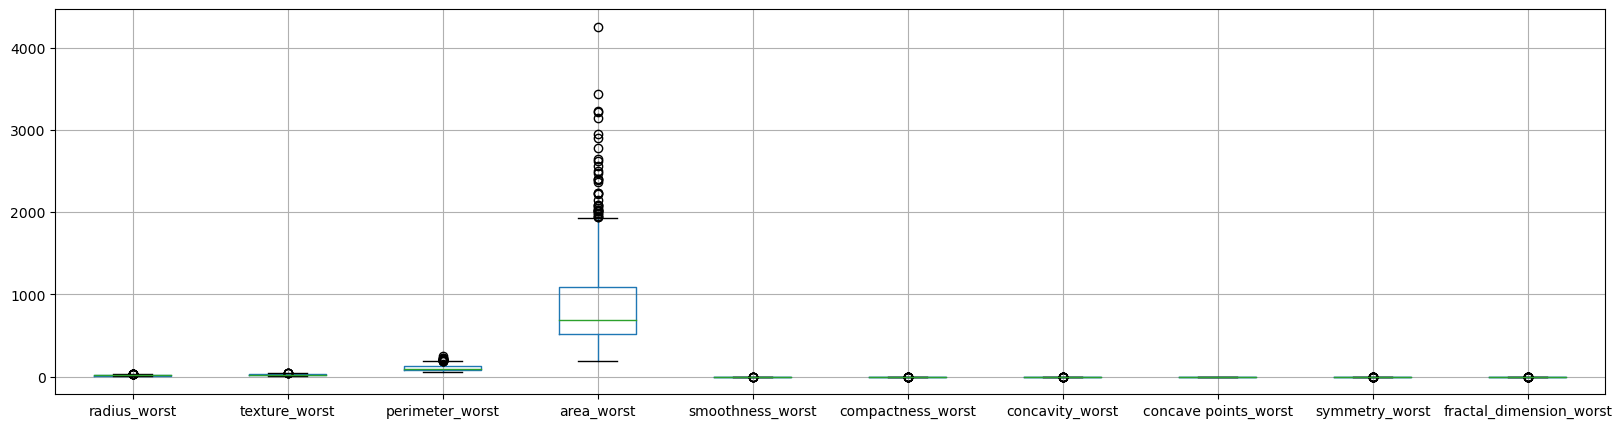

In [11]:
df.loc[:,'radius_worst':'fractal_dimension_worst'].boxplot(figsize=(20,5))
plt.show()

All attributes, except `concave points_worst`, have outliers. We will apply `RobustScaler` to them.

Let's also examine the histograms of all attribtes.

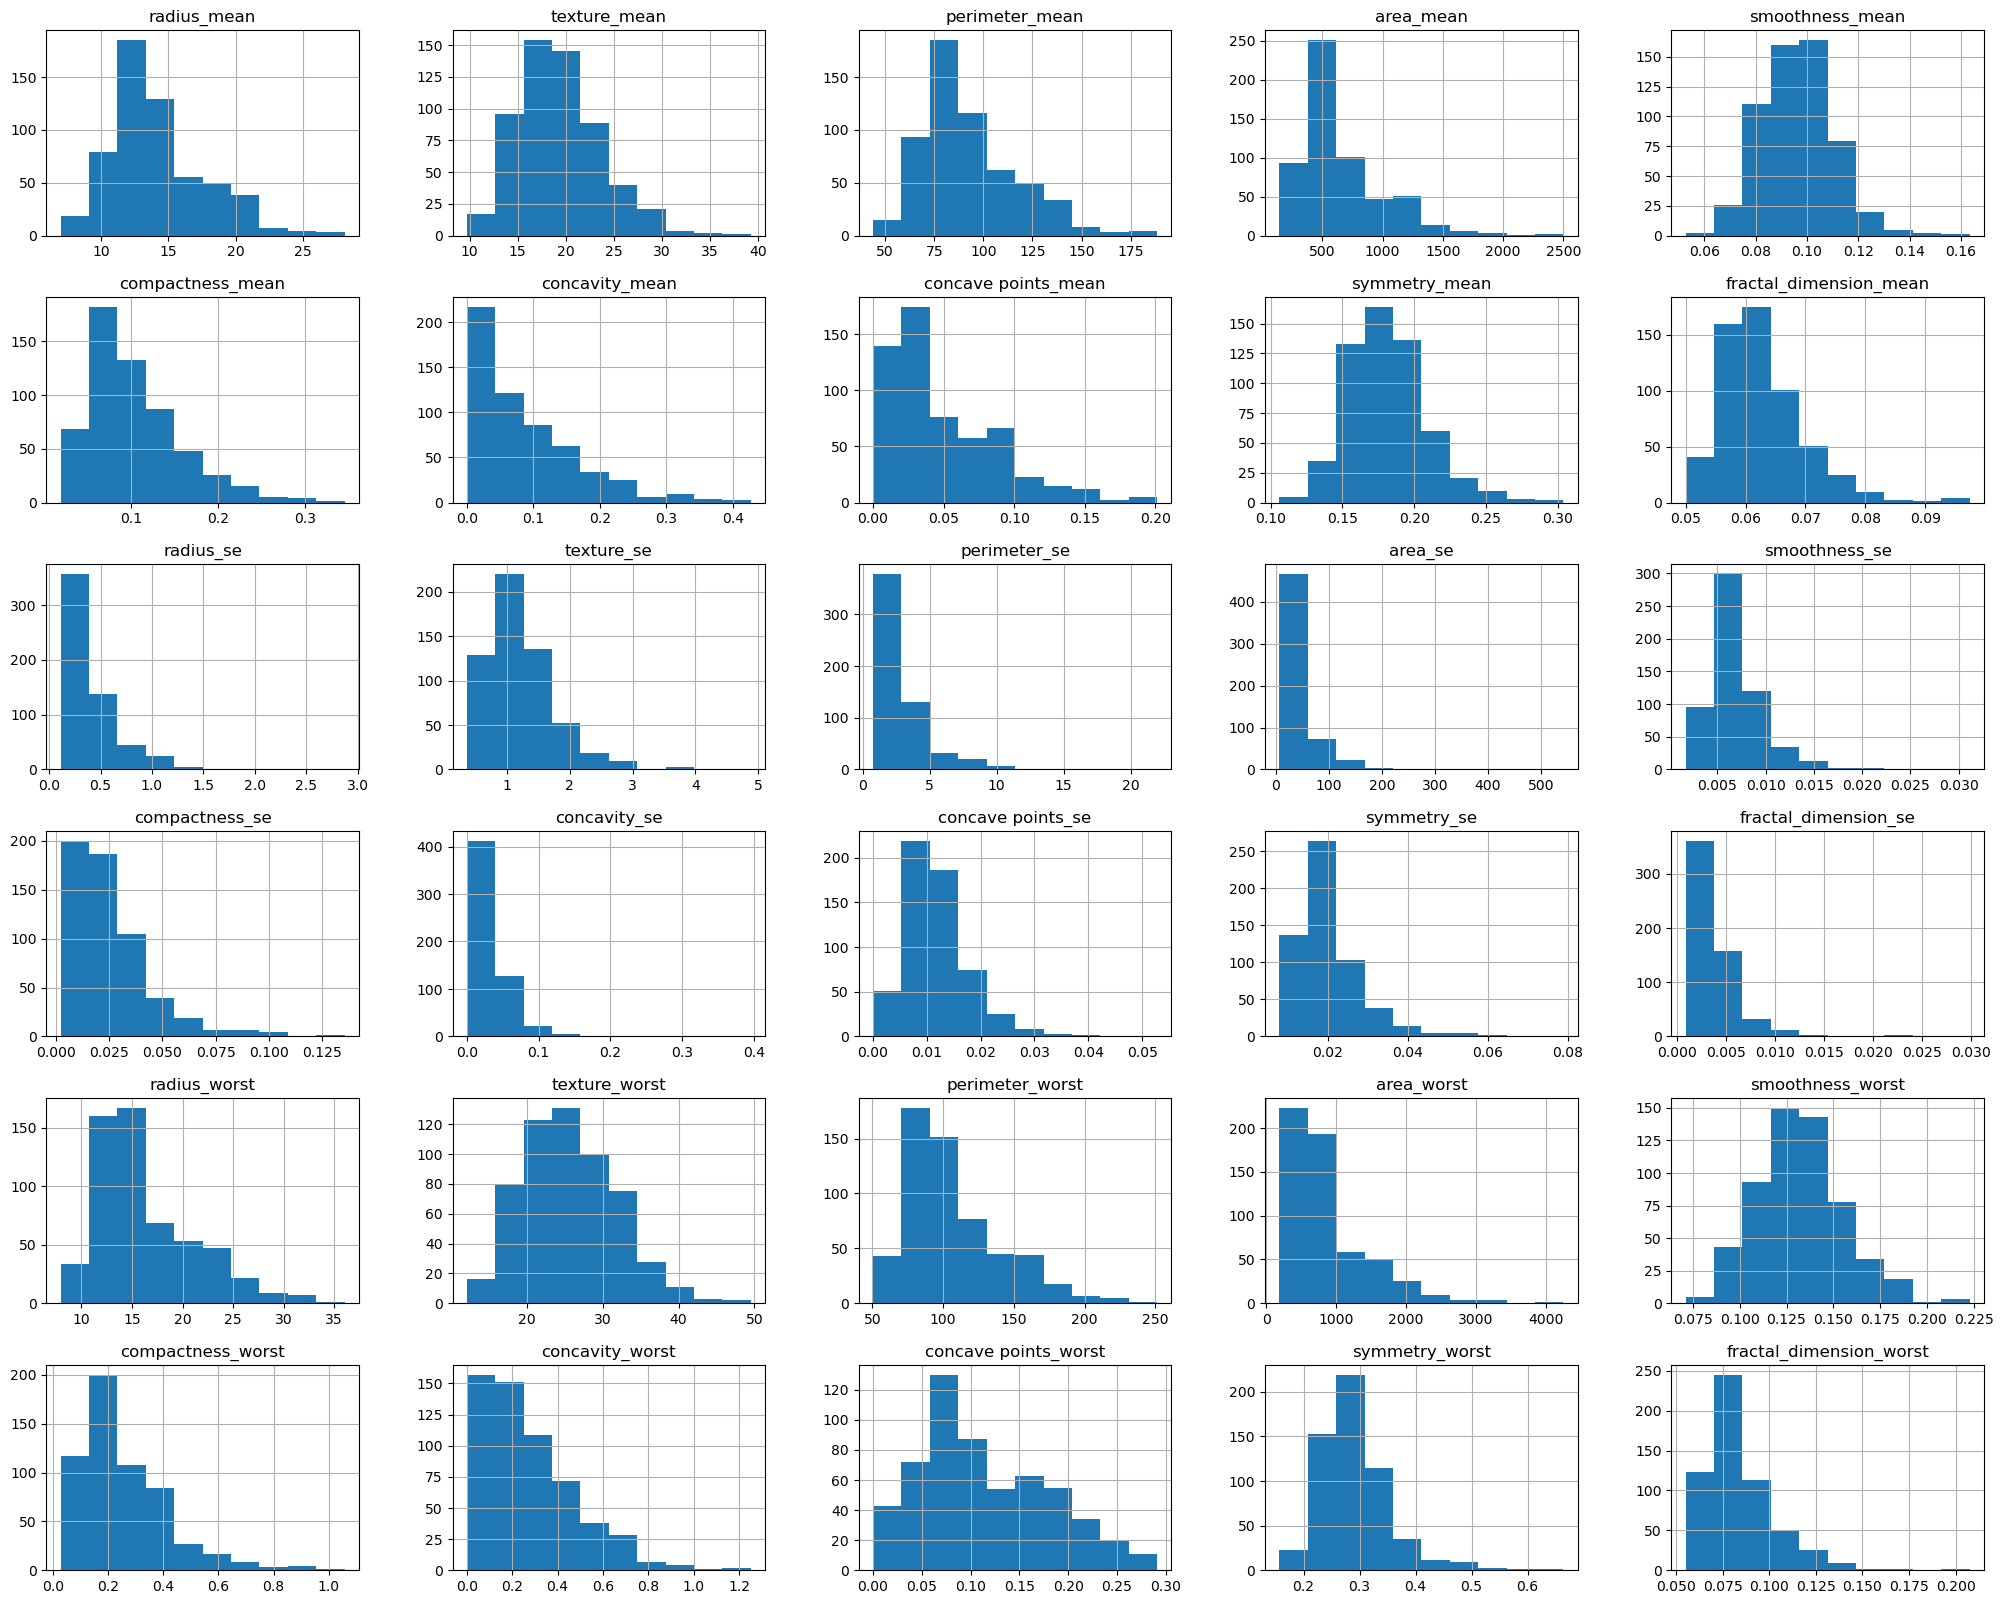

In [12]:
df.hist(bins=10, figsize=(25, 20));

It looks like all attributes are slightly skewed to the left and may benefit from a log transformation. All except the six attributes whose names start with concave and concavity do not contain 0s and we will apply log transformation to them. To the six attributes with 0s we will apply cubic root transformation instead. The goal here is also to demonstrate how different data preparation can be applied to different groups of attributes.

## Data Preparation

First, we transform the `diagnosis` column to binary.

In [13]:
mapper = {'M': 1, 'B': 0}
df['diagnosis'] = df['diagnosis'].replace(mapper)
df['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

Next we split the columns into a target *`y`* and predictors *`X`*.

In [14]:
y = df['diagnosis']
X = df.drop('diagnosis', axis=1)

We will attempt training SVM and Random Forest classifiers. We will tune their parameters, compare them and choose the best classifier for our problem. Here we will prepare a scikit-learn pipeline for data preparation (preprocessing pipeline), which we will apply later. The use of his pipelines ensures that preprocessing is applied separately to any training validation and test dataset without data leakage.

First, we will partition the `predictors` into three groups, to which we will apply different data preparation.

In [15]:
# group 1
columns_no_outliers = ['concave points_worst']

In [16]:
# group 2
columns_outliers_and_zeros = ['concavity_mean','concave points_mean','concavity_se','concave points_se','concavity_worst'];

In [17]:
# group 3: all other predictors
columns_outliers_no_zeros = [item for item in list(X.columns) 
                             if item not in columns_no_outliers and item not in columns_outliers_and_zeros]

# verify the correct columns are selected
print(columns_outliers_no_zeros)
print(len(columns_outliers_no_zeros))

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'symmetry_worst', 'fractal_dimension_worst']
24


Then we can build the preprocessing pipeline by using Pipeline and ColumnTransformer as follows.

In [18]:
outliers_no_zeros_pipeline = Pipeline(
    steps = [
        ("log_transform", FunctionTransformer(np.log)), 
        ("scaler", RobustScaler())
    ]
)

outliers_and_zeros_pipeline = Pipeline(
    steps = [
        ("cubic_root_transform", FunctionTransformer(np.cbrt)),
        ("scaler", RobustScaler())
    ]
)

preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("outliers_no_zeros", outliers_no_zeros_pipeline, columns_outliers_no_zeros),    
        ("outliers_and_zeros", outliers_and_zeros_pipeline, columns_outliers_and_zeros),
        ("no_outliers", FunctionTransformer(np.cbrt), columns_no_outliers)
    ],
    remainder="passthrough" # note there are no remaining columns in this example
)

Now we can split the dataset into a training and test sets.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

The parameter `stratify=y` ensures both classes are represented in the same proportion in both the training and the test sets.

## Model Training

### SVM

Next, we train an SVM classifier with the training set and a range of possible parameters in order to find the best parameters for SVM by cross-validation. To do this we will build another pipeline which includes the preprocessing pipeline and the SVM classifier. The pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation.

In [20]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

Let's visualise the pipeline.

In [21]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('outliers_no_zeros',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['radius_mean',
                                                   'texture_mean',
                                                   'perimeter_mean',
                                                   'area_mean',
                                                   'smoothness_mean',
                                                   'compactness_mean',
                                                   'symmetry_mean',
                                                   'fractal_dimension_mean',
                                                   'radi...
                                                   'fractal_dimension_worst']),
                                                 ('outliers_and_zeros',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['concavity_mean',
                                                   'concave points_mean',
                                                   'concavity_se',
                                                   'concave points_se',
                                                   'concavity_worst']),
                                                 ('no_outliers',
                                                  FunctionTransformer(func=<ufunc 'cbrt'>),
                                                  ['concave points_worst'])])),
                ('svm', SVC(probability=True))])

Now, let's train the model by exploring various combinations of values of the parameters of the predictor, i.e. SVM. Note that we can also add the parameters of the transformers (the ones included in the preprocessing part of the pipeline) to the parameter grid.

In [1]:
# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #training happens here! SVM is trained 48x5 = 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

NameError: name 'GridSearchCV' is not defined

The parameter `refit=True` makes the GridSearchCV train an SVM classifier on the **whole training set** with the best parameters found. This best SVM model can then be accessed via the `.best_estimator_` attribute of the GridSearchCV.

### Random Forest

Let's repeat the same experiment but with the Random Forest classifier.

In [23]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

Let's visualise the pipeline.

In [24]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('outliers_no_zeros',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['radius_mean',
                                                   'texture_mean',
                                                   'perimeter_mean',
                                                   'area_mean',
                                                   'smoothness_mean',
                                                   'compactness_mean',
                                                   'symmetry_mean',
                                                   'fractal_dimension_mean',
                                                   'radi...
                                                   'fractal_dimension_worst']),
                                                 ('outliers_and_zeros',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['concavity_mean',
                                                   'concave points_mean',
                                                   'concavity_se',
                                                   'concave points_se',
                                                   'concavity_worst']),
                                                 ('no_outliers',
                                                  FunctionTransformer(func=<ufunc 'cbrt'>),
                                                  ['concave points_worst'])])),
                ('rf', RandomForestClassifier())])

Now, let's train the model by exploring various combinations of values of the parameters of the predictor, i.e. Random Forest.

In [25]:
# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.954:
Best parameters:  {'rf__max_depth': 8, 'rf__n_estimators': 30}


## Compare Classifiers on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their results (accuracy, precision, recall, etc.) to choose the better classifier for our problem.

The evaluation function below evaluates a model on a test data set. Note that, the preprocessing pipeline will be automatically applied to the test set. The results returned by the function are a variety of metrics measured on the test set which we will use to compare the models and decide which classifier to choose for training the final model. These metrics are:

- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

To plot ROC curves for the models, we need to ensure that the same fpr (false positive rate) scale is used for all curves. For this reason, we take a scale of 100 equally spaced fpr values between 0 and 1.

In [12]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [27]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

Now we will use the function above to evaluate the best SVM and Random Forest models found by the grid search.

In [13]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

NameError: name 'evaluate_model' is not defined

We will use a pandas bar plot to compare the accuracies of both models as well as their precision, recall and F1-score for class 1. 

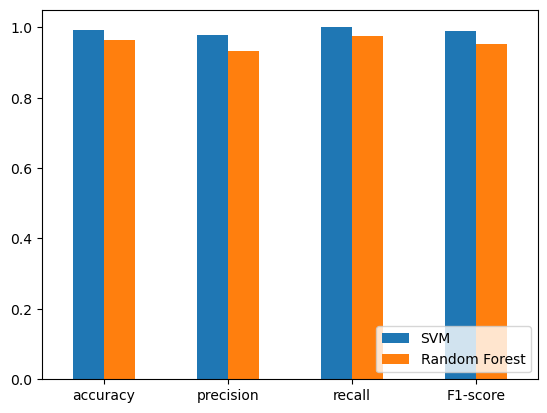

In [29]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

Both classifiers perform well with SVM being better. We can pick SVM to train a final model on the whole dataset. These results will vary slightly when you rerun this notebook. Ideally, the code could be enhanced to run the entire experiment multiple times and average the results.

We can also examine the ROC curves of the two classifiers for class 1.

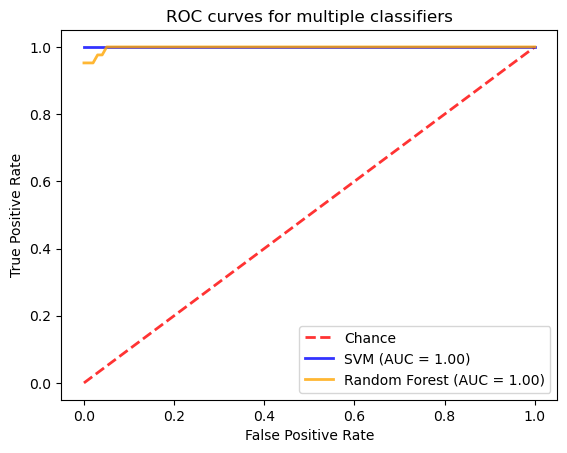

In [30]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

The ROC curves confirm that both classifiers perform significantly better than a random guess (the red dashed `no skill` line). 

## Train the Final Model

Finally, we can train an SVM model with all data we have, assuming that the more data we have the better the model.

In [31]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

We can also store this model on disk.

In [32]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))